In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
## define object and image points as global to make them accesible within functions
global objpoints, imgpoints

In [3]:
## camera calibration with all available images

import glob

%matplotlib inline

def cal_camera():
    # Read in and make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')


    # Arrays to store object points and image points from all images
    objpoints_ng = []  # 3D
    imgpoints_ng = []  # 2D

    # Prepare object plane
    objp = np.zeros((9*6,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x-y coordinates


    for fname in images:
        # read image
        img = mpimg.imread(fname)
        # convert image to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # if corners are found, add object points, image points
        if ret == True:
            imgpoints_ng.append(corners)
            objpoints_ng.append(objp)

            #draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.imshow(img)
    return objpoints_ng, imgpoints_ng

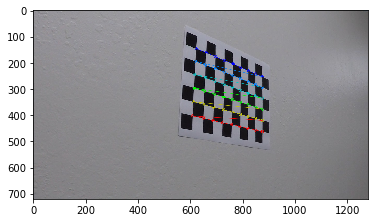

In [4]:
## cal_camera function call
objpoints, imgpoints = cal_camera()

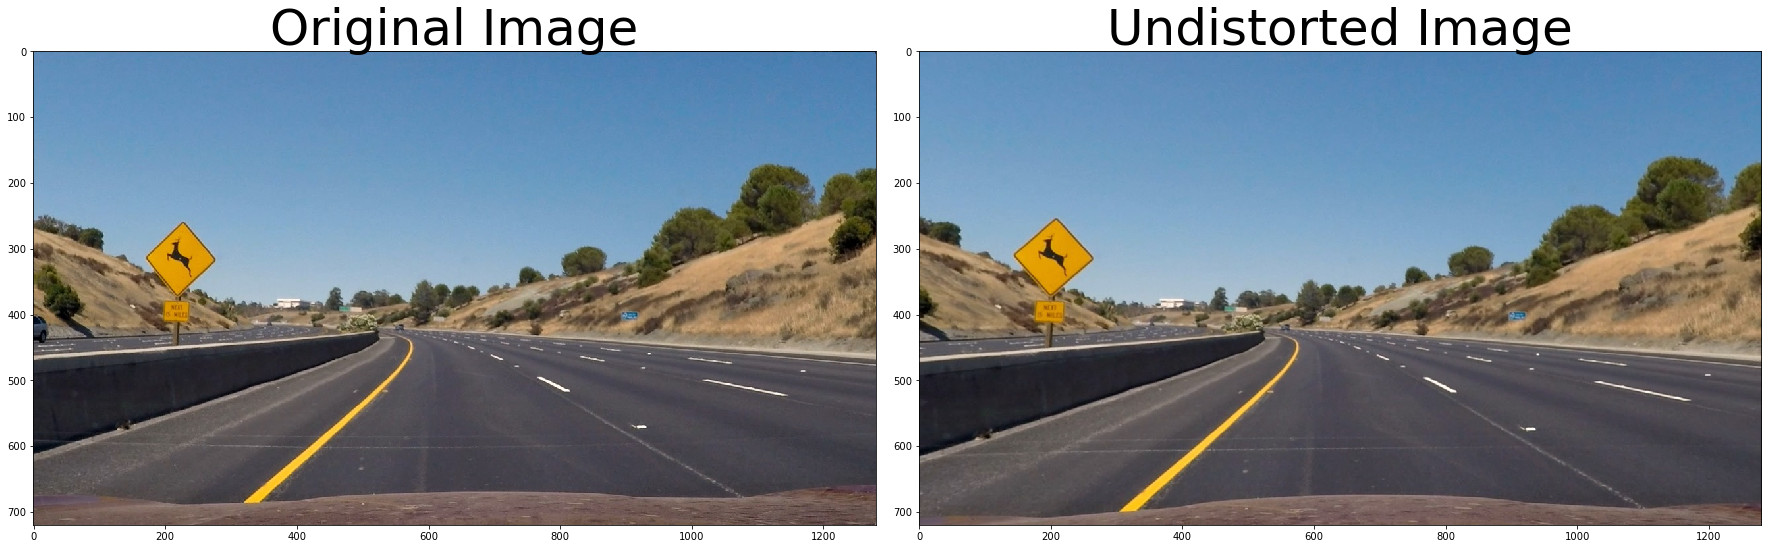

In [5]:
# IMAGE DISTORTION CORRECTION

# function to correct image distortion
# @param img : image to be corrected
# @param objpoints : 3D object ponts
# @param imgpoints : 2D image points
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    grayTest = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = \
    cv2.calibrateCamera(objpoints, imgpoints, grayTest.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Read the test image
# imageTest = mpimg.imread('./test_images/straight_lines2.jpg')
imageTest = mpimg.imread('./test_images/test2.jpg')

# call undistortion to confirm functionality
undistorted = cal_undistort(imageTest, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(imageTest)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
# COLOR & GRADIENT THRESHOLD

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor ( img, cv2.COLOR_RGB2GRAY )
    # Calculate directional gradient
    if orient=='x':
        grad = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        grad = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_grad = np.absolute(grad)
    
    scaled_sobel_Abs = np.uint8(255*abs_grad/np.max(abs_grad))
    # Apply threshold
    
    grad_binary = np.zeros_like(scaled_sobel_Abs)
    grad_binary[ (scaled_sobel_Abs >= thresh[0]) & (scaled_sobel_Abs <= thresh[1]) ] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor ( img, cv2.COLOR_RGB2GRAY )
    # Calculate gradient magnitude
    gradx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)

    grady = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobX = np.absolute(gradx)
    abs_sobY = np.absolute(grady)
    
    gradmag = np.sqrt(abs_sobX**2 + abs_sobY**2)
    
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    # Apply threshold
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[ (scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1]) ] = 1
    
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor ( img, cv2.COLOR_RGB2GRAY )
    # Calculate gradient direction
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel ( gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel ( gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobX = np.absolute(sobelx)
    abs_sobY = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dirc_Sobel = np.arctan2(abs_sobY, abs_sobX)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(dirc_Sobel)
    dir_binary[(dirc_Sobel >= thresh[0]) & (dirc_Sobel <= thresh[1])] = 1
    
    # Apply threshold
    return dir_binary



In [7]:
# function to combine all three threshold function
# @param undist : image to be processed
# @return combined : combined binary file from all threshold functions
def col_grad_thresh(undist):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions

    gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(70, 80))
    grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(30, 110))
    mag_binary = mag_thresh(undist, sobel_kernel=ksize, mag_thresh=(50, 120))
    dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.9, 1.2))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

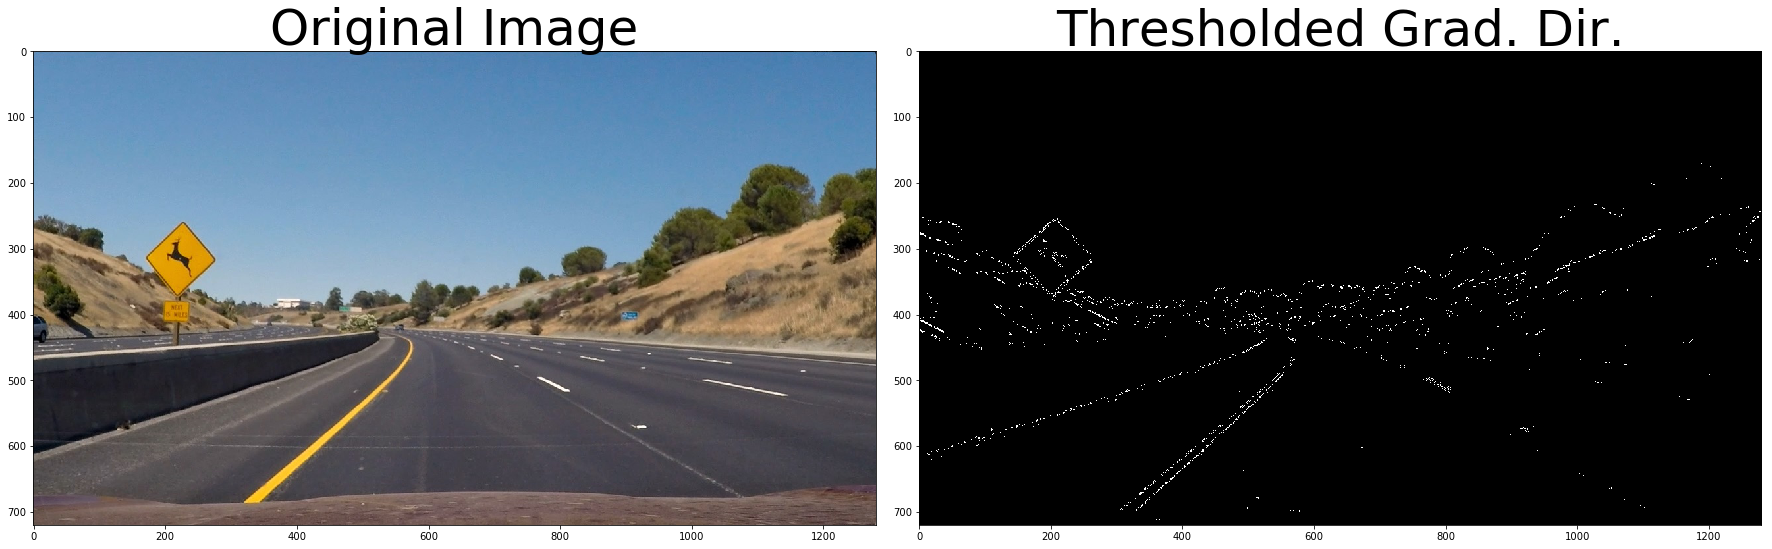

In [8]:
# call thresholding
comb_binary = col_grad_thresh(undistorted)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(imageTest)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(comb_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

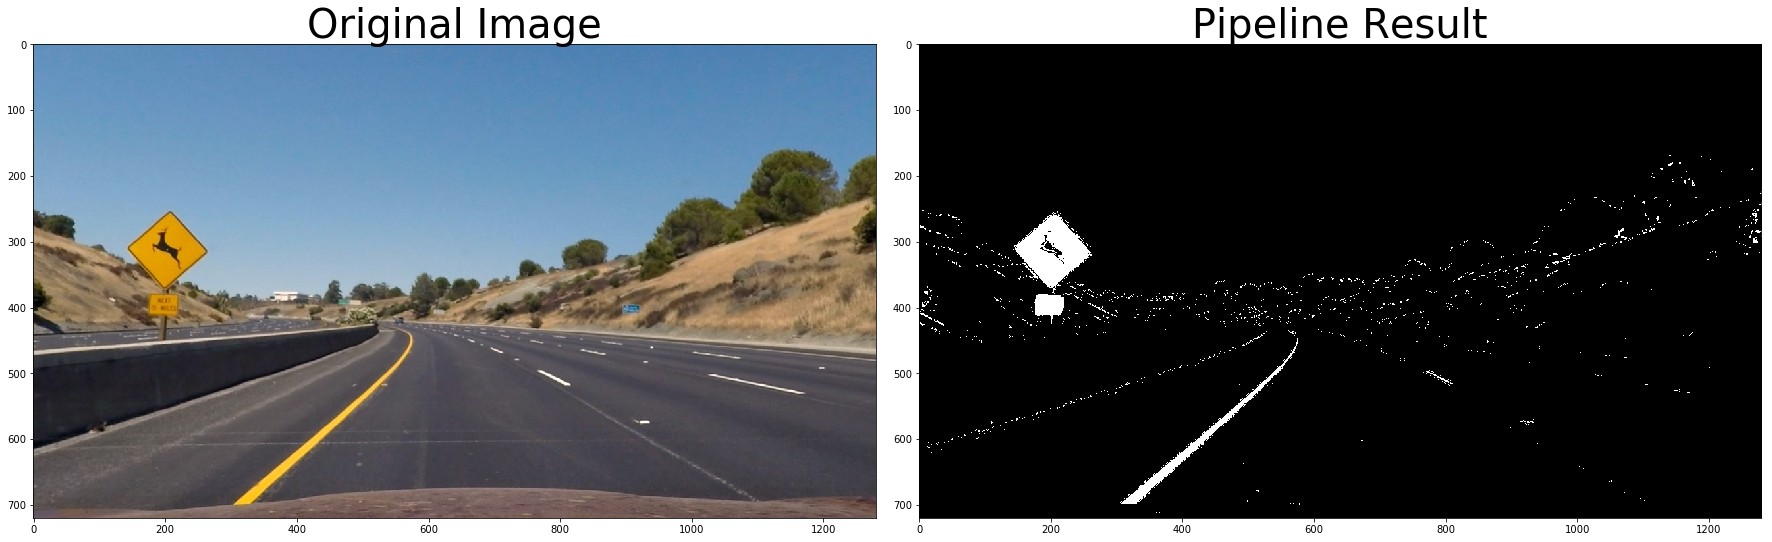

In [9]:
# pipeline function to convert RGB to HLS and apply combined thresholding
# @param img : undistored image
# @param combinedX : combined binary from all threshold functions
# @return color_binary : binary output
def pipeline(img, combinedX, s_thresh=(180, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel

    color_binary = np.zeros_like(s_binary)
    color_binary[(s_binary==1) | (combinedX==1)] = 1
    return color_binary
    
col_grad_binary = pipeline(undistorted, comb_binary)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(col_grad_binary, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [10]:
# Perspective transform function
# @param colGradBin : color gradient binary
# @return warped : top down warped image
# @M : transform matrix
def transform_pers(colGradBin):

    corners=[[595,450],[290,670], [1030,670], [690, 450]]
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])

    offset = 300
    img_size = (colGradBin.shape[1], colGradBin.shape[0])
    dst = np.float32([  [offset, 0],
    [offset, img_size[1]],[img_size[0]-offset, img_size[1]],[img_size[0]-offset, 0]])

    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(colGradBin, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M

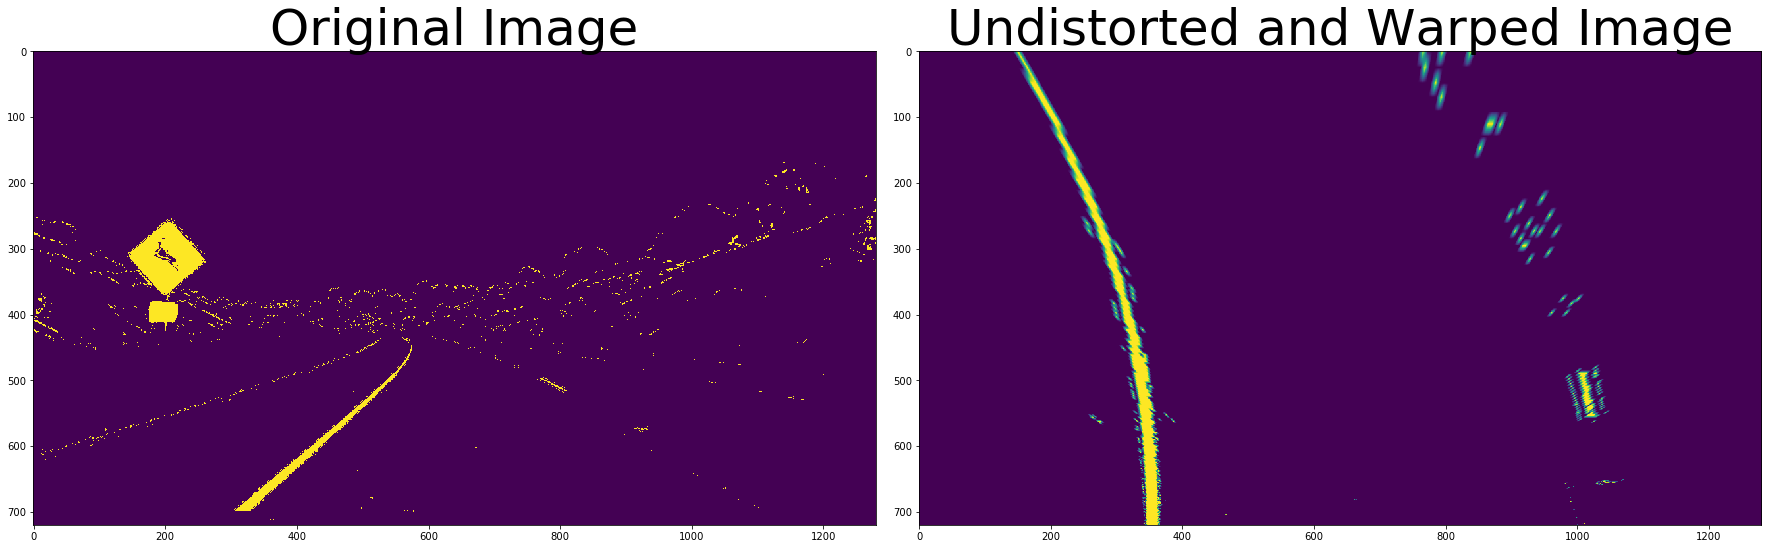

In [11]:
# apply perspective transform
top_down, perspective_M = transform_pers(col_grad_binary)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(col_grad_binary)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [12]:
# Lane finding: Peaks in Histogram (initial lane finding, not relying on available data)

def find_lane(final_binary):
    ## Implement Sliding Windows and Fit a Polynomial
    binary_warped = final_binary
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    half_point_h = int(binary_warped.shape[0] / 2)
    histogram = np.sum(binary_warped[half_point_h:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, leftx, lefty, rightx, righty

(720, 0)

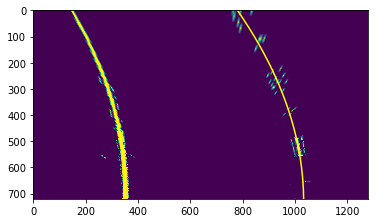

In [13]:
# Visualization for validation purposes
# Generate x and y values for plotting
left_fit, right_fit, leftx, lefty, rightx, righty = find_lane(top_down)
ploty = np.linspace(0, col_grad_binary.shape[0]-1, col_grad_binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(top_down)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [14]:
# inverse transform
# @param undist_img : image to be brought back to horizontal alignment
# @return Minv : inverse transform matrix
def invTransform(undist_img):
    corners=[[595,450],[290,670], [1030,670], [690, 450]]
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])

    offset = 300
    img_size = (undist_img.shape[1], undist_img.shape[0])
    dst = np.float32([  [offset, 0],
    [offset, img_size[1]],[img_size[0]-offset, img_size[1]],[img_size[0]-offset, 0]])
    
    Minv = cv2.getPerspectiveTransform(dst, src)

    return Minv

In [15]:
Minvs = invTransform(col_grad_binary)

# function to draw found lane
def draw_Lane(Minverse, col_grad_binary, undistorted, ploty2, left_fitx2, right_fitx2):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(col_grad_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx2, ploty2]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx2, ploty2])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int32(pts), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minverse, (undistorted.shape[1], undistorted.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    return result

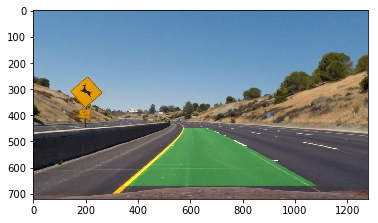

In [16]:
res_ = draw_Lane(Minvs, col_grad_binary, undistorted, ploty, left_fitx, right_fitx)

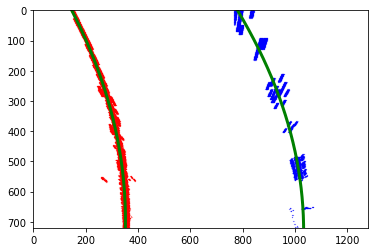

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
mark_size = 0.1
plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [18]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

1171.51573615 1056.51473967


In [19]:
# function to find curvature of the road
def find_curvature(ploty, lefty_local, leftx_local, righty_local, rightx_local):    
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty_local*ym_per_pix, leftx_local*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty_local*ym_per_pix, rightx_local*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad

In [20]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [21]:
# function to find lanes, relying on previously found lane information

def findLane2(binary_warped_n, left_fit2, right_fit2):    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped_n.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 40
    left_lane_inds = ((nonzerox > (left_fit2[0]*(nonzeroy**2) + left_fit2[1]*nonzeroy + 
    left_fit2[2] - margin)) & (nonzerox < (left_fit2[0]*(nonzeroy**2) + 
    left_fit2[1]*nonzeroy + left_fit2[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit2[0]*(nonzeroy**2) + right_fit2[1]*nonzeroy + 
    right_fit2[2] - margin)) & (nonzerox < (right_fit2[0]*(nonzeroy**2) + 
    right_fit2[1]*nonzeroy + right_fit2[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit2 = np.polyfit(lefty, leftx, 2)
    right_fit2 = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty_l2 = np.linspace(0, binary_warped_n.shape[0]-1, binary_warped_n.shape[0] )
    left_fitx_l2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
    right_fitx_l2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]
    return ploty_l2, left_fitx_l2, right_fitx_l2, left_fit2, right_fit2, lefty, leftx, righty, rightx

In [22]:
def find_Position(left_p, right_p):
    center = float((left_p + right_p)/2)
    dev = center - 360
    return dev*0.0037

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [24]:
# function to put text on image
def addCurveNPost(final_image_no_text, curv1):
    font = cv2.FONT_HERSHEY_SIMPLEX
    result2 = cv2.putText(final_image_no_text, curv1, (20,40), font, 0.5, (255,255,255), 1, cv2.LINE_AA)
    return result2
def addCurveNPost2(final_image_no_text, curv2):
    font = cv2.FONT_HERSHEY_SIMPLEX
    result3 = cv2.putText(final_image_no_text, curv2, (20,65), font, 0.5, (255,255,255), 1, cv2.LINE_AA)
    return result3
def addCurveNPost3(final_image_no_text, post):
    font = cv2.FONT_HERSHEY_SIMPLEX
    result4 = cv2.putText(final_image_no_text, post, (20,90), font, 0.5, (255,255,255), 1, cv2.LINE_AA)
    return result4

In [25]:
# declare an object to hold necessary line information
myLine = Line()
myLine.radius_of_curvature = 0,0

# Pipeline to process video
def process_img_ALF(processing_image):
        
    undistorted2 = cal_undistort(processing_image, objpoints, imgpoints)
    #return undistorted
    comb_binary2 = col_grad_thresh(undistorted2)
    col_grad_binary2 = pipeline(undistorted2, comb_binary2)
    top_down, perspective_M = transform_pers(col_grad_binary2)
    left_fit2, right_fit2, leftx, lefty, rightx, righty = find_lane(top_down)
    # if the first frame, use findLane to find lanes
    if myLine.radius_of_curvature[0] == 0:
        ploty_in = np.linspace(0, col_grad_binary2.shape[0]-1, col_grad_binary2.shape[0] )
        left_fitx2 = left_fit2[0]*ploty_in**2 + left_fit2[1]*ploty_in + left_fit2[2]
        right_fitx2 = right_fit2[0]*ploty_in**2 + right_fit2[1]*ploty_in + right_fit2[2]
    # if not the first frame, use findLane2 to find lane (search a limited range)    
    else:
        ploty_in, left_fitx2, right_fitx2, left_fit2, right_fit2, \
        lefty, leftx, righty, rightx= findLane2(top_down,myLine.current_fit[0], myLine.current_fit[1] )
        
    myLine.current_fit = [left_fit2, right_fit2]
    Minvs2 = invTransform(col_grad_binary2)
    myLine.radius_of_curvature = find_curvature(ploty_in, lefty, leftx, righty, rightx)
    myLine.line_base_pos = find_Position(left_fitx2[0], right_fitx2[0])
    with_lanes = draw_Lane(Minvs2, col_grad_binary2, undistorted2, ploty_in, left_fitx2, right_fitx2)
    with_crurv1= addCurveNPost(with_lanes, 'Left= ' + str(myLine.radius_of_curvature[0])+'m' )
    with_crurv2= addCurveNPost2(with_lanes, 'Right= ' + str(myLine.radius_of_curvature[1])+'m' )
    with_post = addCurveNPost3(with_lanes, 'Position= ' + str(myLine.line_base_pos)+'m')
    return with_post


[MoviePy] >>>> Building video C:\Users\nxa04630\Desktop\project_video_result.mp4
[MoviePy] Writing video C:\Users\nxa04630\Desktop\project_video_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [07:54<00:00,  2.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\Users\nxa04630\Desktop\project_video_result.mp4 

Wall time: 7min 55s


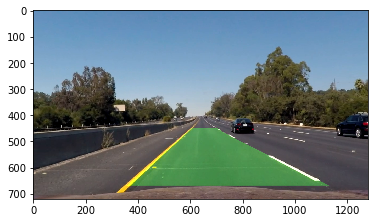

In [26]:
white_output = 'C:\\Users\\nxa04630\\Desktop\\project_video_result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("C:\\Users\\nxa04630\\Desktop\\project_video.mp4")
clip1.save_frame("C:\\Users\\nxa04630\\Desktop\\first_cap.jpg")

white_clip = clip1.fl_image(process_img_ALF) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)